In [29]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.style.use("default")

In [2]:
training_data = datasets.MNIST("./MNIST_DATA/", 
                              download= True, 
                               train = True,
                              )

In [3]:
mean = torch.true_divide((training_data.data), 255).float().mean().item()
std = torch.true_divide((training_data.data), 255).float().std().item()
print("The mean is: {}, and the standard deviation is: {}".format(mean, std))

The mean is: 0.13066235184669495, and the standard deviation is: 0.30810782313346863


In [4]:
batch_size = 128
img_shape = (28,28)

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((mean,), (std,))
                               ])
training_data = datasets.MNIST("./MNIST_DATA/", 
                               download= True, 
                               train = True,
                               transform= transform,
                              )
testing_data = datasets.MNIST("./MNIST_data/", 
                             download=True,
                              train = False, 
                              transform= transform
                             )

train_loader = torch.utils.data.DataLoader(training_data, 
                                          shuffle= True, 
                                           batch_size = batch_size
                                          )
test_loader = torch.utils.data.DataLoader(testing_data, 
                                           batch_size = batch_size
                                          )

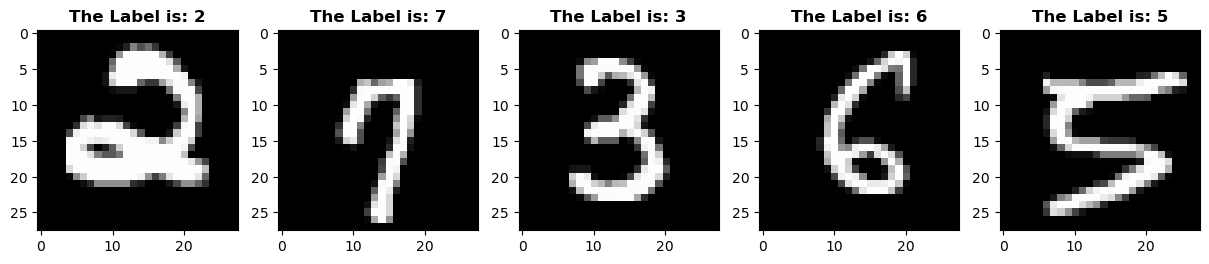

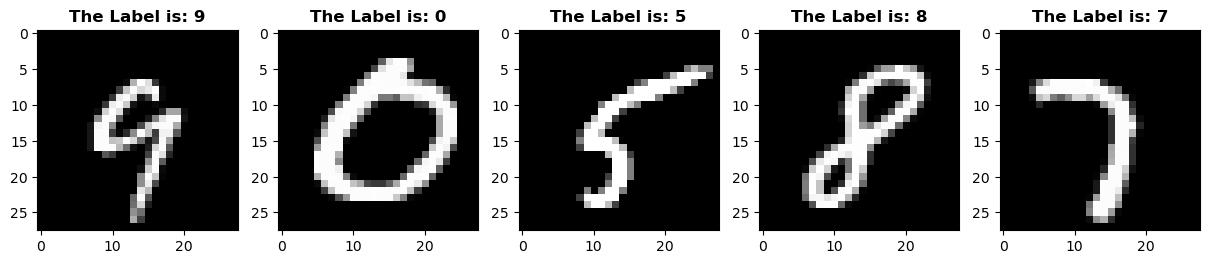

In [6]:
def plot_sample(X, Y, mean, std, img_shape, sample_size = 10, n_rows = 2, n_columns = 5):
    if sample_size != n_rows*n_columns:
        raise Exception("the argument sample_size should equal n_rows * n_columns")
    for i in range(sample_size):
        if i%(sample_size//2) == 0:
            figure = plt.figure(figsize=(15,15))
        ax = plt.subplot(n_rows, n_columns, i+1)
        idx = torch.randint(low = 0, high =len(Y), size = (1,))
        plt.imshow(X[idx].view(*img_shape) * std + mean, cmap='gray')
        ax.set_title('The Label is: {}'.format(Y[idx].item()), fontsize =12, fontweight="bold")
plot_sample(training_data.data, training_data.targets, mean, std, (28,28))

In [7]:
item_frequency = {}
for i in range(10):
    item_frequency[i] = (training_data.targets == i).sum().item()

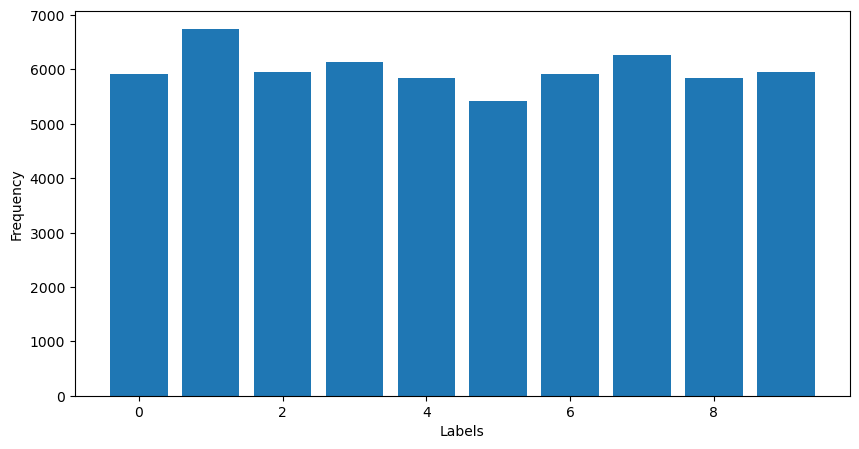

In [8]:
def plot_bar_from_dict(dictionary, x_label = None, y_label= None):
    fig = plt.figure(figsize=(10,5))
    keys = dictionary.keys()
    values = dictionary.values()
    plt.bar(keys, values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
plot_bar_from_dict(item_frequency, "Labels", "Frequency")

In [9]:
 print("the total number of training examples are {}".format(len(training_data)))
 print("the total number of training batches are {}".format(len(train_loader)))    
 print("the total number of testing examples are {}".format(len(testing_data)))
 print("the total number of testing batches are {}".format(len(test_loader)))    

the total number of training examples are 60000
the total number of training batches are 469
the total number of testing examples are 10000
the total number of testing batches are 79


In [10]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size= (3,3), padding = 1) 
        # out_shape (16,28,28)
        # after maxpooling (16, 14, 14)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (3,3), padding= 1) 
        # out_shape (32,14,14)
        # after max_pooling (32,7,7)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(in_features=32*7*7, out_features= 256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size= 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.bnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.bnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(-1, 32*7*7)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [11]:
model = cnn_model()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [12]:
epochs = 20
training_acc = [] 
training_loss = []
testing_acc = [] 
testing_loss = [] 
for epoch in range(epochs):
    correct = 0
    train_loss = 0.0
    model.train()
    for i, (batch, labels) in enumerate(train_loader):
        if CUDA:
            batch = batch.cuda()
            labels = labels.cuda()
        out = model(batch)
        _, predicted = torch.max(out, -1)
        loss = criterion(out, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        correct += (predicted == labels).sum().item()
    training_loss.append(train_loss/len(train_loader))
    training_acc.append(100*(correct/len(training_data)))
    test_loss = 0
    correct = 0
    model.eval()
    for i, (batch, labels) in enumerate(test_loader):
        if CUDA:
            batch = batch.cuda()
            labels = labels.cuda()
        out = model(batch)
        _, predicted = torch.max(out, -1)
        loss = criterion(out, labels)
        test_loss += loss.item()
        correct += (predicted == labels).sum().item()
    testing_loss.append(test_loss/len(test_loader))
    testing_acc.append(100*(correct/ len(testing_data)))
    print("Epoch {}/{}, Train_loss {:.3f}, Train_acc {:.3f}, Test_loss {:.3f}, Test_acc {:.3f}".format(
    epoch+1, epochs, training_loss[-1], training_acc[-1], testing_loss[-1], testing_acc[-1]
    ))

Epoch 1/20, Train_loss 0.263, Train_acc 93.025, Test_loss 0.052, Test_acc 98.380
Epoch 2/20, Train_loss 0.076, Train_acc 97.702, Test_loss 0.038, Test_acc 98.800
Epoch 3/20, Train_loss 0.056, Train_acc 98.260, Test_loss 0.040, Test_acc 98.760
Epoch 4/20, Train_loss 0.049, Train_acc 98.495, Test_loss 0.036, Test_acc 98.830
Epoch 5/20, Train_loss 0.040, Train_acc 98.782, Test_loss 0.040, Test_acc 98.870
Epoch 6/20, Train_loss 0.039, Train_acc 98.790, Test_loss 0.032, Test_acc 98.920
Epoch 7/20, Train_loss 0.036, Train_acc 98.867, Test_loss 0.048, Test_acc 98.640
Epoch 8/20, Train_loss 0.034, Train_acc 98.977, Test_loss 0.037, Test_acc 99.000
Epoch 9/20, Train_loss 0.031, Train_acc 99.018, Test_loss 0.034, Test_acc 99.000
Epoch 10/20, Train_loss 0.033, Train_acc 98.972, Test_loss 0.049, Test_acc 98.850
Epoch 11/20, Train_loss 0.028, Train_acc 99.105, Test_loss 0.037, Test_acc 99.000
Epoch 12/20, Train_loss 0.032, Train_acc 99.057, Test_loss 0.041, Test_acc 98.800
Epoch 13/20, Train_loss 0

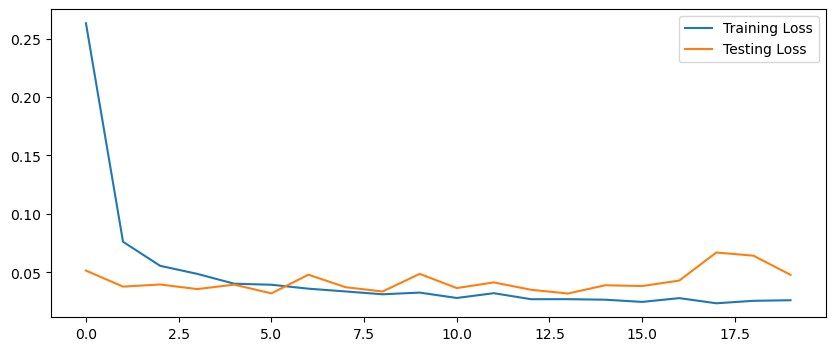

In [17]:
figure = plt.figure(figsize=(10,4))
plt.plot(training_loss, label = "Training Loss")
plt.plot(testing_loss, label = "Testing Loss")
plt.legend()

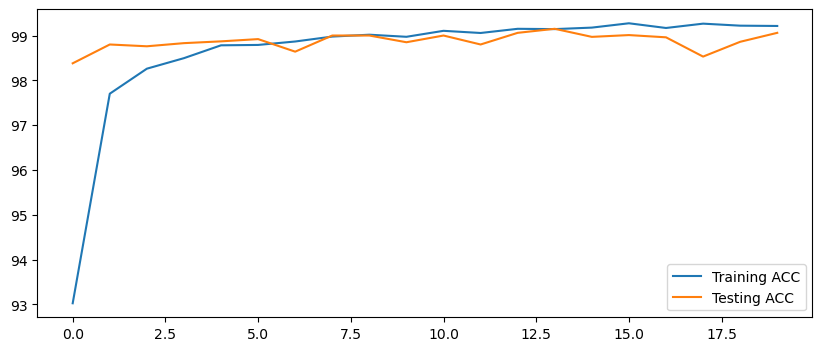

In [18]:
figure = plt.figure(figsize=(10,4))
plt.plot(training_acc, label = "Training ACC")
plt.plot(testing_acc, label = "Testing ACC")
plt.legend()

In [19]:
test_correct = 0
test_total = 0 
Y_prediction = torch.tensor([]).cuda()
for batch, labels in test_loader:
    if CUDA:
        batch = batch.cuda()
    result = model(batch)
    _, predicted = torch.max(result, -1)
    Y_prediction = torch.cat((Y_prediction, predicted))

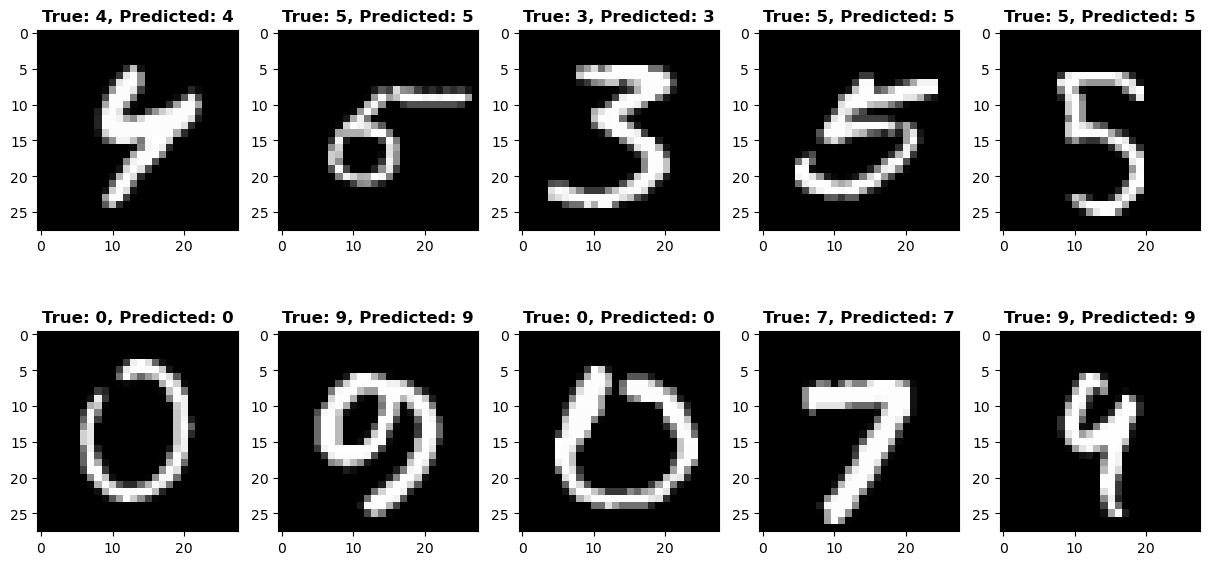

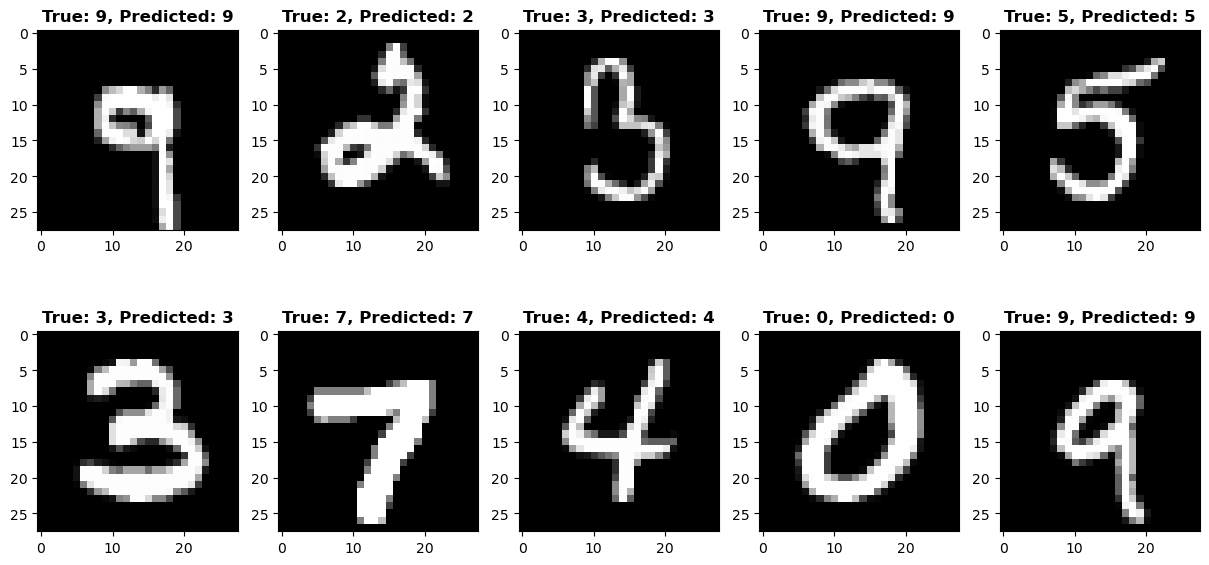

In [25]:
def plot_sample_with_labels(X, mean, std, Y_true, Y_pred, img_shape, sample_size = 10, n_rows = 2, n_columns = 5):
    if sample_size != n_rows*n_columns:
        raise Exception("the argument sample_size should equal n_rows * n_columns")
    if Y_true.shape != Y_pred.shape:
        raise Exception("the shape of Y_true does not match Y_pred shape")
    for i in range(sample_size):
        if i%(sample_size//2) == 0:
            figure = plt.figure(figsize=(15,15))
        ax = plt.subplot(n_rows, n_columns, i+1)
        idx = torch.randint(low = 0, high =len(Y_true), size = (1,))
        plt.imshow((X[idx].view(*img_shape) * std)+mean, cmap='gray')
        if Y_true[idx].item() == Y_pred[idx].int().item():
            ax.set_title('True: {}, Predicted: {}'.format(Y_true[idx].item(), Y_pred[idx].int().item()), fontsize =12, fontweight="bold")
        else:
            ax.set_title('True: {}, Predicted: {}'.format(Y_true[idx].item(), Y_pred[idx].int().item()), color="red", fontsize =12, fontweight="bold")
plot_sample_with_labels(testing_data.data, mean, std, testing_data.targets, Y_prediction, (28,28), sample_size = 20, n_rows = 4)

In [28]:
torch.save(model, "model.pt")